<a href="https://colab.research.google.com/github/hisics/-datawhisperers_final-project_dsml2021/blob/amba/datawhisperers_sentiment_analysis_amazon_apparel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Capstone Project - ML on Apparel Reviews at Amazon US
The Data Whisperers Team ✨  Amba | Bhavya | Sushma | Heba

#### Chosen project : Option 8 - Sentiment Analysis for Ecommerce | Apparel
---



<b>Objectives</b>
- Product owner's perspective: 
  - Quality improvement |
  - Gap analysis | same product different maker?
  - Reputation management
- Investor's perspective: 
  - which product owners improve over time
- Consumer perspective
  - Influencial posts

- ML Practice | Inferrential analysis for positive or negative feedback on products in social media product  


---
Notes: 
* #todo : means to check or come back to the code
* #NOTE : is a reminder or notice 

<b>Understanding the Dataset</b>

* marketplace       : 2 letter country code of the marketplace where the review was written.
*customer_id       : Random identifier that can be used to aggregate *reviews written by a single author.
*review_id         : The unique ID of the review.
*product_id        : The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
*product_parent    : Random identifier (can be used to aggregatereviews for the same product).
*product_title     : Title of the product.
*product_category  : Broad product category.
*star_rating       : The 1-5 star rating of the review.
*helpful_votes     : Number of helpful votes.
*total_votes       : Number of total votes the review received.
*vine              : Review was written as part of the Vine program.
*verified_purchase : The review is on a verified purchase.
*review_headline   : The title of the review.
*review_body       : The review text.
*review_date       : The date the review was written.

From Dany: Look at this document for reference,<br/>
https://colab.research.google.com/drive/1g6ZtYOOhGUj1WsiPpeaVPp5T7VFw234e?usp=sharing

https://www.tensorflow.org/datasets/catalog/amazon_us_reviews

#### Importing libaries and Apparel dataset

In [34]:
# (1) Import libraries
import pandas as pd
import numpy as np
from distutils.util import strtobool


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# for basic visualizations
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# for advanced visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

In [35]:
# (2) Download product reviews from Amazon Datasets
# You can use reviews from Amazon Datasets for a particular product.
# Note that the data are quite large so do not run this cell unless you are willing to wait!
# For reference, visit:
# https://www.tensorflow.org/datasets/catalog/amazon_us_reviews
# https://s3.amazonaws.com/amazon-reviews-pds/readme.html
!curl -O https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  618M  100  618M    0     0  14.0M      0  0:00:44  0:00:44 --:--:-- 15.1M


In [36]:
!echo "y" | gzip -d amazon_reviews_us_Apparel_v1_00.tsv.gz

gzip: amazon_reviews_us_Apparel_v1_00.tsv already exists;	not overwritten


In [37]:
# (3.a) Read the contents of the folder 
!ls

amazon_reviews_us_Apparel_v1_00.tsv	Emoticon_Dict.p
amazon_reviews_us_Apparel_v1_00.tsv.gz	sample_data
cleaned_text_apparel_dataset.csv


In [38]:
# (3.b) Explore data (see what is categorial and numerical)

In [39]:
df = pd.read_table('amazon_reviews_us_Apparel_v1_00.tsv', delim_whitespace=False, error_bad_lines=False, nrows=100000)
df.info()

b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\n'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        100000 non-null  object
 1   customer_id        100000 non-null  int64 
 2   review_id          100000 non-null  object
 3   product_id         100000 non-null  object
 4   product_parent     100000 non-null  int64 
 5   product_title      100000 non-null  object
 6   product_category   100000 non-null  object
 7   star_rating        100000 non-null  int64 
 8   helpful_votes      100000 non-null  int64 
 9   total_votes        100000 non-null  int64 
 10  vine               100000 non-null  object
 11  verified_purchase  100000 non-null  object
 12  review_headline    100000 non-null  object
 13  review_body        99947 non-null   object
 14  review_date        99997 non-null   object
dtypes: int64(5), object(10)
memory usage: 11.4+ MB


In [40]:
# To see how the data looks like and if any is boolean
df.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
99995,US,43330569,R209JPXL8VMOVJ,B00VW37AMU,354148485,"Cybertela Women's Nice Fish You Caught, Can.. ...",Apparel,5,0,0,N,Y,Five Stars,My girlfriend loved it.,2015-05-05
99996,US,25578439,R2ISQWVCXLRNXQ,B00VW367FG,90102146,Cybertela Women's If You Don’t Fish I See.. Fu...,Apparel,4,0,0,N,Y,Four Stars,Great shirt,2015-05-18
99997,US,4282714,RB6XI6R464ZQL,B00VW366V6,789256548,Asgard Blacksmith's Alliance Thor Men's T-Shirt,Apparel,5,0,0,N,Y,Five Stars,Sweet shirt,2015-06-29
99998,US,41294636,R2RW7ZCM8J5YGV,B00VW2UKTG,233863271,Naturana Women's Mastectomy Bra,Apparel,5,0,1,N,Y,Five Stars,very well made,2015-08-06
99999,US,10624669,RN6BUHLG6XC8U,B00VW2TT0W,255023016,Ah Pardon Me My Good Sir I Believe I May Have ...,Apparel,4,0,0,N,Y,So Great!,This was a hit at the baby shower!,2015-07-07


###Cleaning data and converting data types


#### Pre-processing the columns without review text

In [41]:
# Checking if marketplace is only in the US
df.marketplace.unique()

array(['US'], dtype=object)

In [42]:
# Checking unique values of each row in all columns
n = df.nunique(axis=0)
print(
    "Total number of rows in this data set is:{}\nNumber of unique values in each column for in this dataset is:\n"
    .format(len(df)), n)
# outcome --> drop marketplace-category-reviewID
# outcome --> bool vine verified purchase

Total number of rows in this data set is:100000
Number of unique values in each column for in this dataset is:
 marketplace               1
customer_id           85149
review_id            100000
product_id            66229
product_parent        41084
product_title         39656
product_category          1
star_rating               5
helpful_votes           206
total_votes             215
vine                      2
verified_purchase         2
review_headline       53335
review_body           92599
review_date             173
dtype: int64


In [43]:
# Cleaning
# (1) Drop irrelevant info: marketplace + product_category + review_id
df.drop(['marketplace','product_category','review_id'], axis=1, inplace=True)

# (2) Map: vine + verified_purchase (y:1, n:0)
YN_to_bool = {'Y': 1,'N': 0}
df['vine'] = df['vine'].map( YN_to_bool )
df['verified_purchase'] = df['verified_purchase'].map( YN_to_bool)

# (3) Datetime: review_date
df['review_date'] = pd.to_datetime(df['review_date'])
 
# (4) Create a year column for EDA
df['Year'] = df.review_date.dt.year

# (5) Drop the rows where there are no reviews and no review dates
df.dropna(subset = ['review_body'], inplace = True)
df.dropna(subset = ['review_date'], inplace = True)

# (6) Combine the review headline and review date columns
df['review_body'] = df['review_headline'] + ' ' + df['review_body']
del df['review_headline']

# (7) Changing review_body to string & adding a length column for analyzing the length of the reviews
df['review_body']= df['review_body'].apply(str)
df['length'] = df['review_body'].map(str).apply(len)

# (9) Print to see the null rows if any
null_columns=df.columns[df.isnull().any()]
df[df["review_date"].isnull()] #[null_columns] add to tail end to show null columns when that particular colum is null

df.head(1)

,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date,Year,length
0,32158956,B01KL6O72Y,24485154,Easy Tool Stainless Steel Fruit Pineapple Core...,4,0,0,0,1,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKIN...,2013-01-14,2013.0,2961


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99944 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        99944 non-null  int64         
 1   product_id         99944 non-null  object        
 2   product_parent     99944 non-null  int64         
 3   product_title      99944 non-null  object        
 4   star_rating        99944 non-null  int64         
 5   helpful_votes      99944 non-null  int64         
 6   total_votes        99944 non-null  int64         
 7   vine               99944 non-null  int64         
 8   verified_purchase  99944 non-null  int64         
 9   review_body        99944 non-null  object        
 10  review_date        99944 non-null  datetime64[ns]
 11  Year               99944 non-null  float64       
 12  length             99944 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(3)
memory 

In [45]:
df = df.reset_index()

#### Pre-processing the text fields
##### Useful resource for cleaning text
https://medium.com/mlearning-ai/10-python-functions-you-need-to-apply-before-you-build-your-nlp-sentiment-analysis-model-874a37e0217e



In [46]:
# to show full text
# pd.options.display.max_rows
# pd.set_option('display.max_colwidth', None)

In [47]:
# show then count text with emojis
sad_emoji = df.review_body[df['review_body'].str.contains("😠|😔")].count()
happy_loved_emoji = df.review_body[df['review_body'].str.contains("😊|❤️")].count()
thumbs_up_down_emoji = df.review_body[df['review_body'].str.contains("👍|👎")].count()
happy_emoticon = df.review_body[df['review_body'].str.contains(":\)|:D")].count()
sad_emoticon = df.review_body[df['review_body'].str.contains(":\(")].count()

print("Count of dissapointed or angry emoji's 😠 or 😔: \n{}".format(sad_emoji))
print("Count of happy or heart emoji's 😊 or ❤️: \n{}".format(happy_loved_emoji))
print("Count of thumbs up or down emoji's 👍 or 👎: \n{}".format(thumbs_up_down_emoji))
print("Count of happy emoticon :) or :D : \n{}".format(happy_emoticon))
print("Count of sad emoticon :( : \n{}".format(sad_emoticon))

Count of dissapointed or angry emoji's 😠 or 😔: 
28
Count of happy or heart emoji's 😊 or ❤️: 
188
Count of thumbs up or down emoji's 👍 or 👎: 
190
Count of happy emoticon :) or :D : 
1436
Count of sad emoticon :( : 
480


In [48]:
# clean <br /> from text ; the html break line 
print(df.review_body[df['review_body'].str.contains("<br />")].count())

6655


In [49]:
# clean <br /> from text
import re
def remove_HtmlBreak(text):
  text = re.sub("<br />","", text)
  return text

df['review_body'] = df.apply(lambda row: remove_HtmlBreak(row['review_body']), axis=1)
print(df.review_body[df['review_body'].str.contains("<br />")].count())

0


In [50]:
# Function to convert emojis to word
!pip install emot
from emot.emo_unicode import UNICODE_EMOJI

def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

##################################################################
# Function to convert emoticons to word 
#Note remember to upload emoticon dict 
import re
try:
    import cPickle as pickle
except ImportError:
    import pickle  

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def convert_emoticons(text):
   for emot in Emoticon_Dict:
        text = re.sub(u'('+emot+')', "_".join(Emoticon_Dict[emot].replace(",","").split()), text)
   return text

In [51]:
# Apply the convert emoji and emoticons functions to review body
#NOTE converting emojis to word function takes a whole lot of time ~ 1hour 35 mins mins for 100K reviews | changed code slightly to take under 5 mins
df['review_body'] = df['review_body'].apply(convert_emojis)

In [52]:
# df['review_body'] = df['review_body'].apply(lambda row: convert_emoticons(row['review_body']), axis=1)
df['review_body'] = df['review_body'].apply(convert_emoticons)

In [68]:
# checking if emojis and emoticons removed
# df.review_body[df['review_body'].str.contains(":\)|:D")].count()

sad_emoji = df.review_body[df['review_body'].str.contains("😠|😔")].count()
happy_loved_emoji = df.review_body[df['review_body'].str.contains("😊|❤️")].count()
thumbs_up_down_emoji = df.review_body[df['review_body'].str.contains("👍|👎")].count()
happy_emoticon = df.review_body[df['review_body'].str.contains(":\)|:D")].count()
sad_emoticon = df.review_body[df['review_body'].str.contains(":\(")].count()

print("Count of dissapointed or angry emoji's 😠 or 😔: \n{}".format(sad_emoji))
print("Count of happy or heart emoji's 😊 or ❤️: \n{}".format(happy_loved_emoji))
print("Count of thumbs up or down emoji's 👍 or 👎: \n{}".format(thumbs_up_down_emoji))
print("Count of happy emoticon :) or :D : \n{}".format(happy_emoticon))
print("Count of sad emoticon :( : \n{}".format(sad_emoticon))

# For some reason, 1 emitocon was not replaced, applied code below to make sure it's updated
# df.review_body[df['review_body'].str.contains(":\(")] = df.review_body[df['review_body'].str.contains(":\(")].apply(convert_emoticons)


Count of dissapointed or angry emoji's 😠 or 😔: 
0
Count of happy or heart emoji's 😊 or ❤️: 
0
Count of thumbs up or down emoji's 👍 or 👎: 
0
Count of happy emoticon :) or :D : 
0
Count of sad emoticon :( : 
0


In [55]:
# Removing the hashtags
import re      # Import REGEX
def remove_mentions(text):
  text = re.sub("@[A-Za-z0-9_]+","", text)
  text = re.sub("#[A-Za-z0-9_]+","", text)
  return text

df['review_body'] = df.apply(lambda row: remove_mentions(row['review_body']), axis=1)

In [56]:
# Importing text cleaning libraries 
# Tokenizer: Tokenization of data. At one stage we will need to deal with our text as a words list to iterate between the words and apply certain functions on it

import nltk         #Natural language processing tool-kit
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [57]:
# lower all upper case and enumerate words into a list
df['review_body'] = df['review_body'].str.lower()
df['product_title'] = df['product_title'].str.lower()
df['product_title']

0        easy tool stainless steel fruit pineapple core...
1        v28 women cowl neck knit stretchable elasticit...
2        james fiallo men's 12-pairs low cut athletic s...
3        belfry gangster 100% wool stain-resistant crus...
4        jaeden women's beaded spaghetti straps sexy lo...
                               ...                        
99939    cybertela women's nice fish you caught, can.. ...
99940    cybertela women's if you don’t fish i see.. fu...
99941      asgard blacksmith's alliance thor men's t-shirt
99942                      naturana women's mastectomy bra
99943    ah pardon me my good sir i believe i may have ...
Name: product_title, Length: 99944, dtype: object

In [58]:
# Removal of numbers and digits
import re      # Import REGEX
def remove_numbers(text):
  text = re.sub(r'\d+', '', str(text))
  return text

df['review_body'] = df['review_body'].apply(remove_numbers)
df['product_title'] = df['product_title'].apply(remove_numbers)

In [59]:
# Removal of special characters
import re, string, unicodedata # Import Regex, string and unicodedata.
def remove_non_ascii(words):
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return words

df['review_body'] = df['review_body'].apply(remove_non_ascii)
df['product_title'] = df['product_title'].apply(remove_non_ascii)

In [60]:
# Export cleaned to CSV for faster operation?
# df.to_csv('./cleaned_text_apparel_dataset.csv')

### EDA and Feature Engineering

In [29]:
## If reading from cleaned csv 
import pandas as pd
df = pd.read_csv('./cleaned_text_apparel_dataset.csv'')

In [69]:
# Feature Engineering
df_reviews = df[['review_body','star_rating']]
df_reviews.rename(columns = {'review_body':'feature','star_rating':'label'},inplace = True)
df_reviews.info()

# Normalize star ratings to be from 0 to 1 instead 1 to 5 ; for EDA and ML purposes

df_reviews_normalized = df_reviews.copy()
df_reviews_normalized['label'] = (df_reviews_normalized['label'] - df_reviews_normalized['label'].min()) / (df_reviews_normalized['label'].max() - df_reviews_normalized['label'].min())    
print(df_reviews_normalized['label'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99944 entries, 0 to 99943
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  99944 non-null  object
 1   label    99944 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
[0.75 1.   0.5  0.25 0.  ]


In [238]:
# Quick check: Using discriptive statistics + measures of dispersion
# Note: customer_id and product_parent are random numbers not for descriptive analysis
df_discriptive = df.drop(['customer_id', 'product_parent'],axis = 1,inplace = False)
df_discriptive.describe()

# Creating numerical df -> df_num for EDA
# Creating categorical df -> df_cat
cat_list = ['product_parent','product_id','customer_id','product_title','review_body', 'length']

df_num = df.drop(cat_list, inplace = False , axis = 1) 
# df_cat = df[cat_list]

# df.drop(['level_0','index','year'],inplace=True).info()
df_num.info()
df_cat.info()
df_discriptive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99944 entries, 0 to 99943
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   level_0            99944 non-null  int64         
 1   index              99944 non-null  int64         
 2   star_rating        99944 non-null  int64         
 3   helpful_votes      99944 non-null  int64         
 4   total_votes        99944 non-null  int64         
 5   vine               99944 non-null  int64         
 6   verified_purchase  99944 non-null  int64         
 7   review_date        99944 non-null  datetime64[ns]
 8   Year               99944 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 6.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99944 entries, 0 to 99943
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_parent  9

In [232]:
# Discriptive statistics + measures of dispersion by length #ToAskTeam
# df.groupby('length').describe().sample(10)

In [ ]:
df_num.groupby('star_rating').describe()
# df_num

level_0                              ...    Year                
               count          mean           std  ...     50%     75%     max
star_rating                                       ...                        
1            11715.0  50006.595220  28599.448702  ...  2015.0  2015.0  2015.0
2             6685.0  51728.021242  28641.721224  ...  2015.0  2015.0  2015.0
3            10396.0  51692.901982  28339.148258  ...  2015.0  2015.0  2015.0
4            17773.0  51497.934676  28597.875679  ...  2015.0  2015.0  2015.0
5            53375.0  48900.239981  29065.958696  ...  2015.0  2015.0  2015.0

[5 rows x 56 columns]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



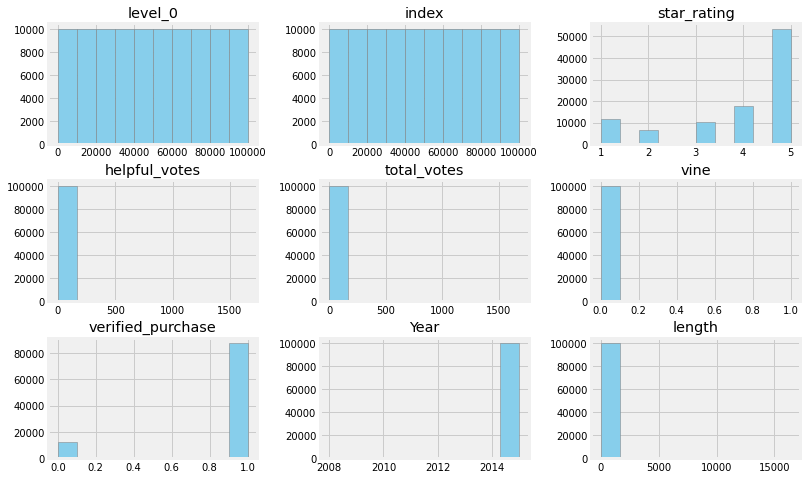

In [233]:
# Check the distribution of the star rating with the DataFrame | reference chart: https://www.datacamp.com/community/tutorials/histograms-matplotlib
# plt.hist(df.star_rating, bins='auto', color = "skyblue", ec='grey')
# plt.gca().set(title='Frequency Histogram | Review Stars |', ylabel='Frequency',xlabel = 'stars',alpha=0.7, rwidth=0.85);
# plt.show()

fig = plt.figure(figsize = (12,8))
ax = fig.gca()
df_discriptive.hist(ax=ax, color = "skyblue", ec='grey')
plt.show()

# Clustering per groups of product parent | votes per product parent
# Sentimet (from -ve) most common words for improvement | from (+ve) most common words for gap analysis
# we will need to scale our stars to min max
# then our scaled stars are our sentiment label, and text is the features? 


In [244]:
# Looking at year and month for review | seems we can extra clean outliers outside 2015 #todo
# df.groupby([df["review_date"].dt.month,df["review_date"].dt.day]).count().plot(kind="bar")
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [ ]:
# Looking at product parent | 
df.product_id.groupby([df["product_parent"],df['star_rating']]).count().plot(kind="bar")

In [ ]:
# Distribution of Amazon Product Ratings
ratings = df["star_rating"].value_counts()
numbers = ratings.index
quantity = ratings.values

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Distribution of Amazon Product Ratings", fontsize=20)
plt.show()

In [ ]:
def sentiment(row):
    
    '''This function returns sentiment value based on the star_rating from the user'''
    
    if row['star_rating'] == 3.0:
        val = 'Neutral'
    elif row['star_rating'] == 1.0 or row['star_rating'] == 2.0:
        val = 'Negative'
    elif row['star_rating'] == 4.0 or row['star_rating'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

### Visualisations

In [ ]:
# reference for visuualisations: https://www.kaggle.com/roshansharma/amazon-alexa-reviews

In [ ]:
# Distribution of ratings
ratings = df['star_rating'].value_counts()

label_rating = ratings.index
size_rating = ratings.values

colors = ['pink', 'lightblue', 'aqua', 'gold', 'crimson']

rating_piechart = go.Pie(labels = label_rating,
                         values = size_rating,
                         marker = dict(colors = colors),
                         name = 'Apparel', hole = 0.3)

df = [rating_piechart]

layout = go.Layout(
           title = 'Distribution of Ratings for Apparel')

fig = go.Figure(data = df,
                 layout = layout)

py.iplot(fig)


In [ ]:
# Distribution of product_title
color = plt.cm.copper(np.linspace(0, 1, 15))
df['product_title'].value_counts().plot.bar(color = color, figsize = (15, 9))
plt.title('Distribution of Product Title', fontsize = 20)
plt.xlabel('product_title')
plt.ylabel('count')
plt.show()

In [ ]:
# Distribution of helpful votes
helpfulVotes = df['helpful_votes'].value_counts()

label_feedback = votes.index
size_feedback = votes.values

colors = ['yellow', 'lightgreen']

votes_piechart = go.Pie(labels = label_votes,
                         values = size_votes,
                         marker = dict(colors = colors),
                         name = 'Apparel', hole = 0.3)

df2 = [votes_piechart]

layout = go.Layout(
           title = 'Distribution of Helpful Votes for Apparel')

fig = go.Figure(data = df2,
                 layout = layout)

py.iplot(fig)

In [ ]:
# Distribution in the length of the reviews
df['length'].value_counts().plot.hist(color = 'skyblue', figsize = (15, 5), bins = 50)
plt.title('Distribution of Length in Reviews')
plt.xlabel('lengths')
plt.ylabel('count')
plt.show()

In [ ]:
# Check some of the reviews according to their lengths
df[df['length'] == 1]['total_votes'].iloc[0]
df[df['length'] == 21]['total_votes'].iloc[0]
df[df['length'] == 50]['total_votes'].iloc[0]
df[df['length'] == 150]['total_votes'].iloc[0]

In [ ]:
# Product title vs product rating
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('fivethirtyeight')

sns.boxenplot(df['product_title'], df['star_rating'], palette = 'spring')
plt.title("product_title vs star rating")
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# product vs. length of rating
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('fivethirtyeight')

sns.swarmplot(data['variation'], df['length'], palette = 'deep')
plt.title("Variation vs Length of Ratings")
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# Helpful ratings vs. mean star rating
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 7)
plt.style.use('fivethirtyeight')

sns.violinplot(df['helpful_votes'], df['star_rating'], palette = 'cool')
plt.title("helpful votes Mean Ratings")
plt.show()

In [ ]:
# Most frequently occuring word - top 20
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.review_body)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

In [ ]:
# total votes vs length
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 7)
plt.style.use('fivethirtyeight')

sns.stripplot(df['total_votes'], data['length'], palette = 'Reds')
plt.title("Votes vs Length")
plt.show()

In [ ]:
# Rating vs. Length vs. product_title
trace = go.Scatter3d(
    x = df['length'],
    y = df['star_rating'],
    z = df['product_title'],
    name = 'Apparel',
    mode='markers',
    marker=dict(
        size=10,
        color = df['star_rating'],
        colorscale = 'Viridis',
    )
)
df = [trace]

layout = go.Layout(
    title = 'Length vs Variation vs Ratings',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    )
    
)
fig = go.Figure(data = df, layout = 
                layout)
iplot(fig)

In [ ]:
#Applying the function in our new column
df['sentiment'] = df.apply(sentiment, axis=1)
df.head()

In [ ]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

# Put features into dataframe
# Distribution of sentiment class
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparing Ratio of Neutral Negative and Positive ratings", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "sentiment", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
sns.despine()

In [ ]:
# Distribution of the retaings
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparing Ratio of Neutral Negative and Positive ratings", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "star_rating", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
sns.despine()

In [ ]:
# Group by product and Rating class
df.groupby("product_title")["review_body"].unique()

In [ ]:
# Group by product and Rating class
df.groupby("product_title")["product_id"].count()

In [ ]:
# Group by product and Rating class
df.groupby("product_title")["sentiment"].unique()

In [ ]:
# (4) Choose the label and features

In [ ]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

In [ ]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
print(df)
# Leaving the text columns , finding the correlation between different features and their influence on score 
plt.figure(figsize = (10,10))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [ ]:
df=df['star_rating'].value_counts().to_frame()
avgdf1 = df.groupby('helpful_votes').agg({'star_rating': np.average})
avgdf2 = df.groupby('product_title').agg({'helpful_votes': np.average})
avgdf3 = df.groupby('star_rating').agg({'helpful_votes': np.average})

trace1 = go.Bar(
    x=avgdf1.index,
    y=round(avgdf1['star_rating'],2),
    marker=dict(
        color=avgdf1['star_rating'],
        colorscale = 'RdBu')
)

trace2 = go.Bar(
    x=df1.index,
    y=df1.Rating,
    marker=dict(
        color=df1['star_rating'],
        colorscale = 'RdBu')
)

trace3 = go.Bar(
    x=avgdf2.index,
    y=round(avgdf2['helpful_votes'],2),
    marker=dict(
        color=avgdf2['helpful_votes'],
        colorscale = 'RdBu')
)

trace4 = go.Bar(
    x=avgdf3.index,
    y=round(avgdf3['helpful_votes'],2),
    marker=dict(
        color=avgdf3['helpful_votes'],
        colorscale = 'Reds')
)

fig = tools.make_subplots(rows=2, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)

fig['layout']['xaxis1'].update(title='product_title')
fig['layout']['yaxis1'].update(title='Average Rating')
fig['layout']['xaxis2'].update(title='Rating')
fig['layout']['yaxis2'].update(title='Count')
fig['layout']['xaxis3'].update(title='product_title')
fig['layout']['yaxis3'].update(title='Average Age of the Reviewers')
fig['layout']['xaxis4'].update(title='star_rating')
fig['layout']['yaxis4'].update(title='Average Age of the Reviewers')

fig['layout'].update(height=800, width=900,showlegend=False)
fig.update_layout({'plot_bgcolor':'rgba(0,0,0,0)',
                   'paper_bgcolor':'rgba(0,0,0,0)'})
#fig['layout'].update(plot_bgcolor='rgba(0,0,0,0)')
#fig['layout'].update(paper_bgcolor='rgba(0,0,0,0)')
py.iplot(fig)

In [ ]:
# # cv = df["product_title"].value_counts()

# trace = go.Scatter3d( x = avgdf1.index,
#                       y = avgdf1['star_rating'],
#                       z = cv[avgdf1.index],
#                       mode = 'markers',
#                       marker = dict(size=10,color=avgdf1['star_rating']),
#                       hoverinfo ="text",
#                       text="Class: "+avgdf1.index+" \ Average Rating: "+avgdf1['star_rating'].map(' {:,.2f}'.format).apply(str)+" \ Number of Reviewers: "+cv[avgdf1.index].apply(str)
#                       )

# data = [trace]
# layout = go.Layout(title="Average Rating & Class & Number of Reviewers",
#                    scene = dict(
#                     xaxis = dict(title='product_title'),
#                     yaxis = dict(title='Average Rating'),
#                     zaxis = dict(title='Number of Sales'),),
#                    margin = dict(l=30, r=30, b=30, t=30))
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig)
# plt.savefig('3D_Scatter.png')

In [ ]:
# Plot number of reviews for top 50 products
products = df["product_id"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

In [ ]:
# Plot number of reviews for top 50 products
products = df["product_title"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

In [ ]:
# Word Count per Review type
from textblob import TextBlob
df['text_word_count']= df.apply(lambda row: len(row['review_body']), axis=1)
# df["text_word_count"] = temp_df["Text"].apply(lambda text: len(text.split()))


In [ ]:
df[df.star_rating==5].text_word_count.median()

In [ ]:
sns.boxplot(x='star_rating',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

In [ ]:
sns.boxplot(x='sentiment',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

In [ ]:
# (6) Confirm data is ready with further exploratory analysis




*   Maximum reviews are positive
*   Product with Max reviews is Tummy slimming belt
*   This shows people mainly target losing weight :)
*   Postive reviews has lesser words compared to Neutral and negative. Neutral commets are ones with most words. Which can be critic comment or unsatisfied customers.





### Popular words in Review

In [ ]:
pos = df_discriptive.loc[df['classes'] == 'positive']
pos = pos[0:25000]

neg = df.loc[df['classes'] == 'negative']
neg = neg[0:25000]

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

def create_Word_Corpus(temp):
    words_corpus = ''
    for val in temp["review_body"]:
        text = str(val).lower()
        #text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus
        


In [ ]:
# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))

In [ ]:
# Plot cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
#Visuallizing popular positive words
plot_Cloud(pos_wordcloud)

In [ ]:
#Visuallizing popular negative words
plot_Cloud(neg_wordcloud)

### Stemming the reviews

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
# Extracting 'reviews' for processing
review_features = df.copy()
review_features = df[['review_body','star_rating']].reset_index(drop=True)
review_features.head()

In [ ]:
#Performing stemming on the review dataframe
ps = PorterStemmer()
from nltk.corpus import stopwords
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['review_body'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review) 

corpus[2]


In [ ]:
print(corpus[1])
review_features.head(1)

### Data Split, Machine Learning

In [ ]:
# (7) Training, Testing (and/or Validation) data split 

# for example, 60/20/20

In [ ]:
# (7.b) If using Deep Learning, building the model

# Add Input Layer
# Add Hidden Layers
# Add Output

In [ ]:
# (8) Training the Machine Learning Model (i.e, Fitting the Model)

In [ ]:
# (9) Evaluate the model metrics for Training (and/or Validation) data

In [ ]:
# (10) Evaluate the model metris for Testing data


# If metrics are poor, optimize either (a) the data, (b) the hyperpamaters

In [ ]:
# (11) Use the model for prediction

In [ ]:
# (12) Write final predicted data  (e.g, to CSV or JSON, etc.)

In [ ]:
df_cleaned = df.head(100000)
df_cleaned['star_rating'].count()
df_cleaned['star_rating'].unique()
df_cleaned['star_rating'].value_counts()
# indexNames = df_cleaned[ df_cleaned['star_rating'] == 'star_rating' ].index
# df_cleaned.drop(indexNames,inplace=True)
# df_cleaned.dropna(inplace=True)

In [ ]:
from nltk.corpus import stopwords
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
df_cleaned.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( df_cleaned['review_body'], df_cleaned['star_rating'], test_size=0.33, random_state=42)

In [ ]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=500,C=0.1,random_state=40,solver='newton-cg')),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=500,C=0.1,random_state=40,solver='newton-cg')),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('clf', DecisionTreeClassifier()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf', DecisionTreeClassifier()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
from sklearn.svm import LinearSVC
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf',LinearSVC()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

#### Using KNN

In [ ]:
def partition(x):
    if x<3:
        return 'Negative'
    elif x>3:
        return 'Positive'
    return 'Neutral'

actualScore = df['star_rating']
positiveNegative = actualScore.map(partition)
df['Score'] = positiveNegative

In [ ]:
df['Time'] = df['review_date']
sortedData = df.sort_values('product_id',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"customer_id","Time","review_body"},keep="first",inplace=False)

final = final[final.helpful_votes >= final.total_votes-final.helpful_votes]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'Positive']
finalp = finalp.sample(frac=0.008,random_state=2) #0.055

finaln = final[final.Score == 'Negative']
finaln = finaln.sample(frac=0.1,random_state=1) #0.25

finalne = final[final.Score == 'Neutral']
finalne = finalne.sample(frac=0.02,random_state=4) #0.25

final = pd.concat([finalp,finaln, finalne],axis=0)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [ ]:
import re
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
all_neutral_words=[]
s=''

for sent in final['review_body'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    if(final['Score'].values)[i] == 'Neutral':
                        all_neutral_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [ ]:
from sklearn.model_selection import cross_val_score

def find_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    #myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,n_jobs=8)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)


    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)

In [ ]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )

In [ ]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

"""
df_test = pd.read_csv('test.csv')

df_test = df_test.dropna()

X_test = df_test['review_body']
y_test = df_test['ratings']

count_vect_test = CountVectorizer() 
final_bow_count_test = count_vect.fit_transform(X_test)
final_bow_np_test = StandardScaler(with_mean=False).fit_transform(final_bow_count_test)

X_test = final_bow_np_test
"""

In [ ]:
import numpy as np

In [ ]:
myList = list(range(0,15))

optimal_k = find_optimal_k(X_train ,y_train,myList)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=8)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [ ]:
print("Accuracy for KNN model with Bag of words is ",round(accuracy_score(y_test ,pred),3))

#### EDA by Spacy

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
stopwords = list(STOP_WORDS)

In [ ]:
import string
punctuations = string.punctuation
from spacy.lang.en import English
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    return mytokens
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
#Custom Transformer using spaCy
class predictors(TransformerMixin):
    
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self,deep=True):
        return{}
    
# Basic function to clean the text
def clean_text(text):
    return text.strip().lower()
tfdifVect = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
from spacy import displacy

In [ ]:
# Breaking down a review into dependencies
doc = nlp(df['review_body'][8]) 
displacy.render(doc,style='dep',jupyter=True)

In [ ]:
#X = data.drop('star_rating',axis=1)
X = df['review_body']
y = df['sentiment']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

#### Support Vector Machines

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                 ('tfidfVect', tfdifVect),
                ('classifier',classifier),])

In [ ]:
y_train

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                 ('tfidfVect', tfdifVect),
                ('classifier',classifier),])

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
count = 1
for (sample,pred) in zip(X_test[0:10],sample_prediction[0:10]):
    print('\n',count,')')
    print(sample,"'PREDICTION':", pred)
    count += 1

In [ ]:
#Test Accuracy
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not great"])

#### Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier =  LogisticRegression()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
#Test Accuracy
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not great"])

#### Decision Trees


In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not great"])

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not good"])

In [ ]:
pipe.predict(["Nice dress, good fitting"])

In [ ]:
pipe.predict(["perfect size, good material"])